In [11]:
# 코랩에서 그래프 한글 깨짐 방지
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# 실행하고 런타임 다시 시작

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.6f}'.format

# 그래프에서 한글 깨짐 방지
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')

In [14]:
df=pd.read_csv('/content/drive/MyDrive/datasets/원본data.csv', index_col=0)
df_origin=pd.read_csv('/content/drive/MyDrive/datasets/원본data.csv', index_col=0)

In [15]:
## 경제심리지수, 기계류내수출,수출입물가비율 ,장단기금리차, 외환보유액, 뉴스심리지수, 원달러,G20, 천연가스--> 정상적이다

## G7. G20은 비슷하므로 G7 drop
#df2=df2.drop('G7',axis=1)

df['재고순환지표']+=25
df['재고순환지표']=np.log1p(df['재고순환지표']/df['재고순환지표'].shift(1))
df['건설수주액']=np.log1p(df['건설수주액']/df['건설수주액'].shift(1))
df['코스피']=np.log1p(df['코스피']/df['코스피'].shift(1))
df['원엔']=np.log1p(df['원엔']/df['원엔'].shift(1))
df['원위안']=np.log1p(df['원위안']/df['원위안'].shift(1))
df['CD']=np.log1p(df['CD']/df['CD'].shift(1))
df['유가']=np.log1p(df['유가']/df['유가'].shift(1))
df['미장단기']+=0.9
df['미장단기']=np.log1p(df['미장단기']/df['미장단기'].shift(1))
df['거래량']=np.log1p(df['거래량']/df['거래량'].shift(1))
df['구리']=np.log1p(df['구리']/df['구리'].shift(1))
df['은']=np.log1p(df['은']/df['은'].shift(1))
df['금']=np.log1p(df['금']/df['금'].shift(1))

df['종가']=np.log(df['종가']/df['종가'].shift(1))
df=df.dropna(axis=0)


In [16]:
df.drop(['유가','은','원위안','외환보유액'],axis=1,inplace=True)

In [17]:
from statsmodels.tsa.statespace.varmax import VARMAX

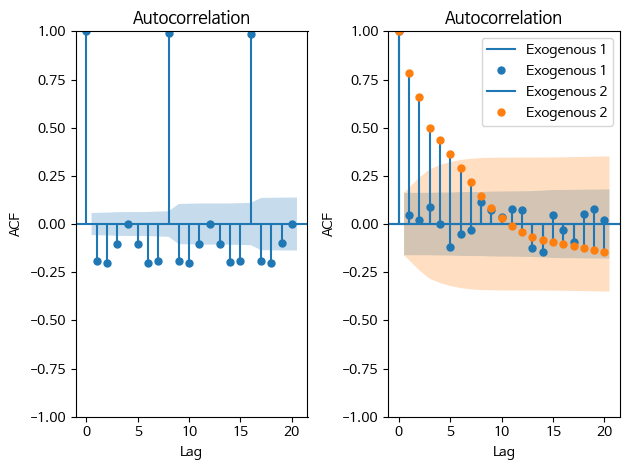

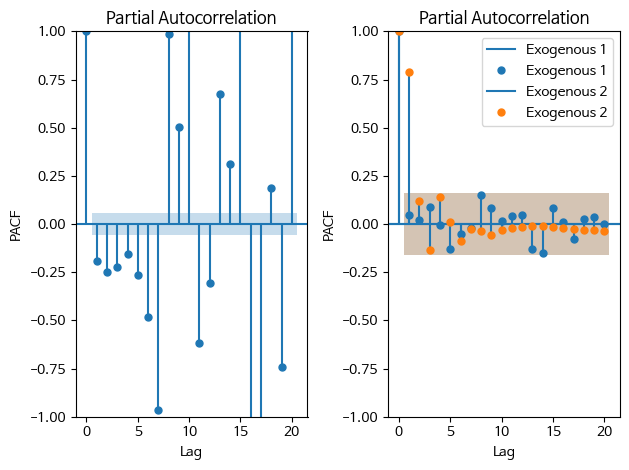

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 그래프에서 한글 깨짐 방지
import matplotlib.pyplot as plt

# plt.rc('font', family='NanumBarunGothic')
data =df.iloc[:147][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']].values.flatten()
exog= df.iloc[:147][['원엔','G20']].values

# 내생 변수와 외생 변수를 함께 고려하여 ACF와 PACF를 그리는 함수 정의
def plot_acf_pacf(data, exog, lags):
    # 내생 변수의 ACF 그래프
    plt.subplot(121)
    plot_acf(data, lags=lags, ax=plt.gca())
    plt.xlabel('Lag')
    plt.ylabel('ACF')

    # 외생 변수의 ACF 그래프
    plt.subplot(122)
    for i in range(exog.shape[1]):
        plot_acf(exog[:, i], lags=lags, ax=plt.gca(), label=f'Exogenous {i+1}')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 내생 변수의 PACF 그래프
    plt.subplot(121)
    plot_pacf(data, lags=lags, ax=plt.gca())
    plt.xlabel('Lag')
    plt.ylabel('PACF')

    # 외생 변수의 PACF 그래프
    plt.subplot(122)
    for i in range(exog.shape[1]):
        plot_pacf(exog[:, i], lags=lags, ax=plt.gca(), label=f'Exogenous {i+1}')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.legend()

    plt.tight_layout()
    plt.show()


# ACF와 PACF를 그리기
max_lag = 20  # 최대 시차(lag)
plot_acf_pacf(data, exog, lags=max_lag)

In [19]:
# train 데이터 프레임 정의
train_data = df.iloc[:147][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']]
train_exog = df.iloc[:147][['원엔','G20']]
train = pd.DataFrame(train_data)
train_exog = pd.DataFrame(train_exog)

# test 데이터 프레임 정의
test_data = df.iloc[147:][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']]
test_exog = df.iloc[147:][['원엔','G20']]
test = pd.DataFrame(test_data)
test_exog = pd.DataFrame(test_exog)

In [20]:
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
import joblib

# 관련 데이터 프레임을 NumPy 배열로 변환
train_data = df.iloc[:147][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']].values
train_exog = df.iloc[:147][['원엔','G20']].values
test_data = df.iloc[147:][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','종가']].values
test_exog = df.iloc[147:][['원엔','G20']].values

# 예측값을 저장할 빈 리스트 초기화
pred = []

# VARMAX 모델 초기화 및 학습
model_varmax = VARMAX(endog=train_data, exog=train_exog, order=(2,6))
model_fit = model_varmax.fit(disp=False)
for t in range(len(test_data)):
    # 한 단계 예측
    forecast = model_fit.forecast(steps=1, exog=[train_exog[-2]])
    joblib.dump(model_fit, 'varmax_update.pkl')
    # 예측값을 리스트에 추가
    pred.append(forecast[0])

    # 새로운 데이터로 VARMAX 모델 재학습
    train_data = np.concatenate([train_data, [test_data[t]]])
    train_exog = np.concatenate([train_exog, [test_exog[t]]])
    model_varmax = VARMAX(endog=train_data, exog=train_exog, order=(2,6))
    model_varmax.initialize_approximate_diffuse()
    model_fit = model_varmax.fit(disp=False)

    print(f'{t+1}번째')



1번째
2번째
3번째
4번째
5번째
6번째
7번째
8번째
9번째
10번째
11번째
12번째
13번째
14번째
15번째
16번째
17번째
18번째
19번째
20번째
21번째
22번째
23번째
24번째
25번째
26번째
27번째
28번째
29번째
30번째
31번째
32번째
33번째
34번째
35번째
36번째


In [21]:
pred

[array([ 9.76365403e-01,  6.95894867e+01,  9.57956651e+01,  6.68878184e-01,
         5.58603946e-01,  1.30514029e+03,  5.97797333e-01, -2.05874790e-02]),
 array([ 3.21711115e-01,  6.31899913e+01,  9.86346352e+01,  6.74560889e-01,
         4.70660252e-01,  1.24078222e+03,  6.03378001e-01, -1.61182135e-01]),
 array([1.41270404e+00, 6.24297246e+01, 9.76014211e+01, 7.06065437e-01,
        7.03203913e-01, 1.26181957e+03, 6.07633161e-01, 1.39454729e-02]),
 array([ 1.16215263e+00,  7.74856633e+01,  9.42342328e+01,  6.91002721e-01,
         5.31727819e-01,  1.16181264e+03,  6.55284638e-01, -9.12139722e-02]),
 array([1.01227980e+00, 8.26958620e+01, 9.49621359e+01, 7.06708237e-01,
        6.54443409e-01, 1.12740952e+03, 6.75885557e-01, 3.82342106e-03]),
 array([ 1.98114347e+00,  7.86773588e+01,  9.59692751e+01,  7.06924503e-01,
         7.86799584e-01,  1.14627896e+03,  6.20093015e-01, -1.30372182e-02]),
 array([ 1.17510159e+00,  8.60144049e+01,  9.53800414e+01,  6.84404493e-01,
         6.96872

In [24]:
# 예측값 리스트를 DataFrame으로 변환
pred_df = pd.DataFrame(pred, columns=train.columns,index=test.index)
pred_df.reset_index(drop=True, inplace=True)
pred_df.to_csv('varmax_final2_update.csv')

In [23]:
pred_df

,재고순환지표,경제심리지수,수출입물가비율,코스피,장단기,원달러,CD,종가
0,0.976365,69.589487,95.795665,0.668878,0.558604,1305.140290,0.597797,-0.020587
1,0.321711,63.189991,98.634635,0.674561,0.470660,1240.782224,0.603378,-0.161182
2,1.412704,62.429725,97.601421,0.706065,0.703204,1261.819565,0.607633,0.013945
3,1.162153,77.485663,94.234233,0.691003,0.531728,1161.812636,0.655285,-0.091214
4,1.012280,82.695862,94.962136,0.706708,0.654443,1127.409519,0.675886,0.003823
5,1.981143,78.677359,95.969275,0.706925,0.786800,1146.278963,0.620093,-0.013037
6,1.175102,86.014405,95.380041,0.684404,0.696873,1089.069041,0.715130,-0.091707
7,0.825828,88.209415,95.672898,0.713351,0.718797,1140.753819,0.682611,0.161405
8,0.882854,87.981870,95.176952,0.710185,0.939133,1092.421769,0.738317,-0.009134
9,0.768259,96.368917,95.366695,0.726128,0.734878,1067.744270,0.705748,0.147754


In [ ]:
# pred_df.iloc[20]=[0.925058674,110.2271412,88.60595327,0.696405183,1.055167848,1104.011643,0.662007531,0.045289569]

In [25]:
pred_df.index=test.index

In [26]:
test['종가']

Date
2020-05    0.116203
2020-06    0.098670
2020-07   -0.033584
2020-08    0.081749
2020-09    0.160504
2020-10    0.030546
2020-11   -0.035161
2020-12    0.096859
2021-01    0.102901
2021-02    0.124357
2021-03   -0.040466
2021-04   -0.007162
2021-05   -0.014312
2021-06    0.078524
2021-07    0.014431
2021-08   -0.060784
2021-09   -0.012423
2021-10   -0.087624
2021-11    0.033397
2021-12   -0.081583
2022-01    0.058456
2022-02   -0.082949
2022-03   -0.041036
2022-04    0.015845
2022-05    0.030236
2022-06    0.006243
2022-07   -0.090402
2022-08    0.063660
2022-09   -0.015851
2022-10   -0.079724
2022-11   -0.028687
2022-12    0.030443
2023-01   -0.066097
2023-02    0.068706
2023-03    0.033561
2023-04   -0.000645
Name: 종가, dtype: float64

In [27]:
show=pd.concat([test['종가'], pred_df['종가']], axis=1, keys=['예측', '실제'])

In [28]:
a=df_origin[148:][['종가']]
show=pd.concat([show,a],axis=1).rename(columns={'종가':'실제종가'})

In [29]:
b=df_origin[147:]['종가'] * np.exp(show['예측'])
b=b.dropna()
show=pd.concat([show,b],axis=1)
show.rename(columns={0 : '예측종가'},inplace=True)
show

,예측,실제,실제종가,예측종가
Date,,,,
2020-05,0.116203,-0.020587,1047.710000,1176.813410
2020-06,0.098670,-0.161182,1156.360000,1276.277261
2020-07,-0.033584,0.013945,1118.170000,1081.241265
2020-08,0.081749,-0.091214,1213.420000,1316.783760
2020-09,0.160504,0.003823,1424.680000,1672.720989
2020-10,0.030546,-0.013037,1468.870000,1514.430663
2020-11,-0.035161,-0.091707,1418.120000,1369.123431
2020-12,0.096859,0.161405,1562.350000,1721.248923
2021-01,0.102901,-0.009134,1731.680000,1919.362257


In [34]:
# show.to_csv('VARMAX최종결과2.csv')

In [30]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Calculate mean absolute error
mae = mean_absolute_error(show['실제종가'],show['예측종가'])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(show['실제종가'], show['예측종가'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

MAE: 88.384823
MSE: 11749.550388
RMSE: 108.395343


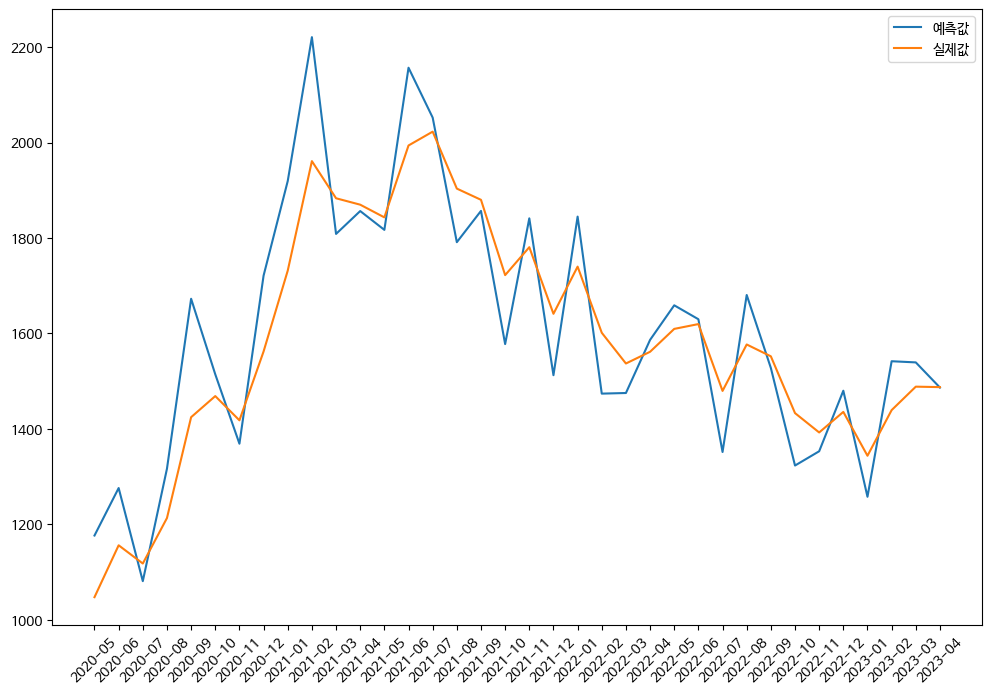

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

plt.plot(test.index, show['예측종가'],label='예측값')
plt.plot(test.index, show['실제종가'],label='실제값')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [32]:
df_origin_gr=df_origin.iloc[:149][['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']]

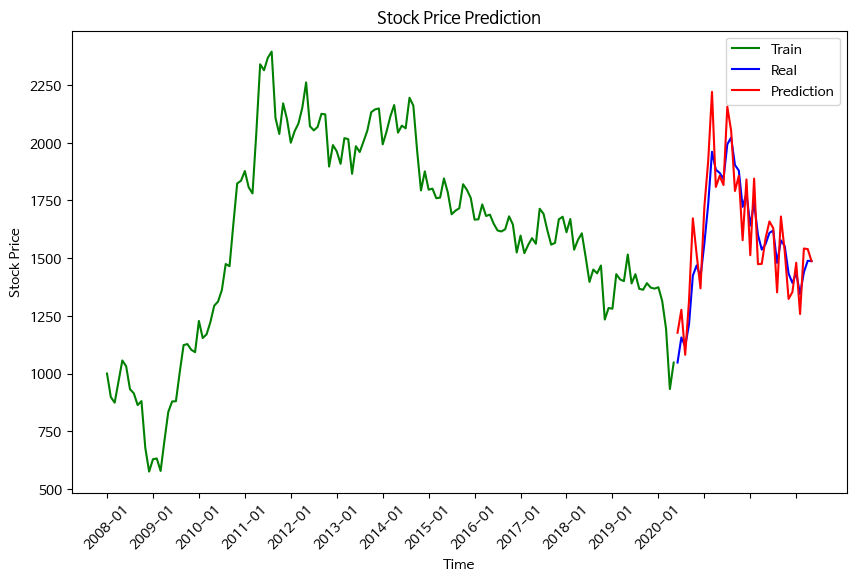

In [36]:
plt.figure(figsize=(10,6))
# Add the training set to the plot:
plt.plot(df_origin_gr['종가'], color='green', label='Train')
# Plot the test and prediction data:
plt.plot(range(len(df_origin_gr['종가']), len(df_origin_gr['종가'])+len(show['실제종가'])), show['실제종가'], color='blue', label='Real')
plt.plot(range(len(df_origin_gr['종가']), len(df_origin_gr['종가'])+len(show['실제종가'])), show['예측종가'], color='red', label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(range(0, len(df_origin_gr['종가'])+len(show['실제종가']), 12), rotation=45)

plt.legend()
plt.show()

## 다시 접속하면 여기서 부터 실행시켜서 결과 보기


In [ ]:
import pandas as pd
show=pd.read_csv('/content/VARMAX최종결과.csv',index_col=0)
show

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Calculate mean absolute error
mae = mean_absolute_error(show['실제종가'],show['예측종가'])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(show['실제종가'], show['예측종가'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

#Calculate mean_absolute_percentage_error
mape = mean_absolute_percentage_error(show['실제종가'],show['예측종가'])
print('MAPE: %f' % mape)

MAE: 88.384823
MSE: 11749.550388
RMSE: 108.395343
MAPE: 0.057182


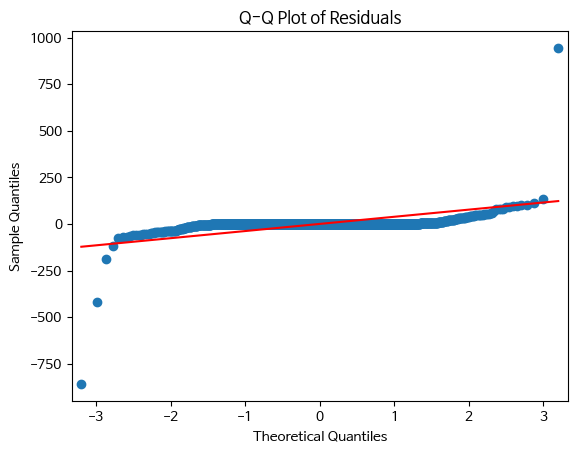

Normality test statistic: 1102.7542153020675
p-value: 3.4670866789762303e-240


In [39]:
from scipy.stats import normaltest
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Residuals
residuals = model_fit.resid


# Residual analysis


# Q-Q Plot
sm.qqplot(residuals.flatten(), line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# 잔차의 정규성 검정
statistic, p_value = normaltest(residuals.flatten())

print("Normality test statistic:", statistic)
print("p-value:", p_value)


In [42]:
residuals = pd.DataFrame(residuals,columns=train.columns).reset_index(drop=True)

In [43]:
residuals.corr()

,재고순환지표,경제심리지수,수출입물가비율,코스피,장단기,원달러,CD,종가
재고순환지표,1.000000,0.256022,0.206014,0.353290,0.644932,-0.516558,-0.780518,0.360472
경제심리지수,0.256022,1.000000,0.410637,0.585265,-0.194645,0.066226,0.091392,-0.427001
수출입물가비율,0.206014,0.410637,1.000000,0.929612,0.464980,0.641911,0.285285,0.359178
코스피,0.353290,0.585265,0.929612,1.000000,0.497128,0.489396,0.155909,0.305013
장단기,0.644932,-0.194645,0.464980,0.497128,1.000000,-0.012376,-0.447748,0.773269
원달러,-0.516558,0.066226,0.641911,0.489396,-0.012376,1.000000,0.817838,0.085665
CD,-0.780518,0.091392,0.285285,0.155909,-0.447748,0.817838,1.000000,-0.318410
종가,0.360472,-0.427001,0.359178,0.305013,0.773269,0.085665,-0.318410,1.000000


In [44]:
from statsmodels.stats.stattools import durbin_watson

durbin_res1 = pd.DataFrame([residuals.columns,
                           [round(x,2) for x in durbin_watson(residuals)]]).T
durbin_res1.set_index([0],inplace=True)
durbin_res1.index.name = 'Variable'
durbin_res1.columns=['Durbin-Watson (lag 1)']
durbin_res1


,Durbin-Watson (lag 1)
Variable,
재고순환지표,2.010000
경제심리지수,0.330000
수출입물가비율,2.000000
코스피,1.980000
장단기,2.640000
원달러,1.320000
CD,1.530000
종가,1.960000


In [45]:
def cal_dw_stat(res, lag):
    n = len(res)
    a = np.zeros(n)
    a[0] = -1
    a[lag] = 1
    a = np.expand_dims(a, axis=1)
    for i in range(n-lag-1):
        temp = np.zeros(n)
        temp[i+1] = -1
        temp[i+1+lag] = 1
        temp = np.expand_dims(temp, axis=1)
        a = np.concatenate([a, temp], axis=1)

    H = a.dot(a.T)
    dw_stat = res.dot(H.dot(res)) / np.sum(np.square(res - np.mean(res)))
    return dw_stat

dw_values = []
for col in residuals.columns:
    dw_value = cal_dw_stat(residuals[col].values.flatten(), lag=2)
    dw_values.append(dw_value)

durbin_res = pd.DataFrame({'Durbin-Watson (lag 2)': dw_values}, index=residuals.columns)
durbin_res.index.name = 'Variable'
durbin_res


,Durbin-Watson (lag 2)
Variable,
재고순환지표,2.141330
경제심리지수,0.534880
수출입물가비율,1.011389
코스피,0.577369
장단기,1.342179
원달러,2.441049
CD,2.658918
종가,1.177838


In [46]:
pred = pd.Series(show['예측종가'].values.flatten()).pct_change()
test = pd.Series(show['실제종가'].values.flatten()).pct_change()

In [47]:
re = 1
for i in range(len(pred)):
  if pred[i] > 0:
    re *= (1+test[i])

re

2.5986729480166972